In [ ]:
from zipfile import ZipFile
import os                                    # import necessary libraries and unzip zip file to load train and test 
os.chdir("/content/sample_data")
print(os.getcwd())
with ZipFile("image_data.zip", 'r') as zip:
    zip.extractall()


/content/sample_data


In [ ]:
import torch
from torchvision import transforms 
import numpy as np
import glob
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import os
import torchvision.models as models


In [ ]:
## transform images using pytorch packages       
# transform them by resizing image from 500*300 to 224 * 224 and normalize them
# Flip images to introduce variations 

transformer = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_folder_path = "/content/sample_data/train_data"
test_folder_path = "/content/sample_data/test_data"

# path to load data

In [ ]:
train_folder = torchvision.datasets.ImageFolder(train_folder_path,transform=transformer)
print(len(train_folder))
img_1,label = train_folder[0]           # Load images through imagefolder function and check dimensions
print(img_1.shape,label)



test_folder = torchvision.datasets.ImageFolder(test_folder_path,transform=transformer)
img_2,label = test_folder[2]           # Load images through imagefolder function and check dimensions
print(img_2.shape,label)   
print(train_folder.classes)                                    

900
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
['Benign', 'Malignant']


In [ ]:
img_2

tensor([[[ 1.0502,  0.4679,  0.4851,  ...,  0.2624,  0.2624,  0.9646],
         [-0.2684, -1.4672, -1.3302,  ..., -1.9295, -1.9809, -0.5082],
         [-0.1486, -1.3644, -1.2959,  ..., -1.9638, -1.9809, -0.4739],
         ...,
         [ 0.3994, -0.5253, -0.4397,  ..., -1.1932, -1.2959, -0.0629],
         [ 0.3309, -0.5938, -0.4911,  ..., -1.2445, -1.3302, -0.1486],
         [ 1.3584,  0.9132,  0.9646,  ...,  0.6221,  0.4851,  1.0502]],

        [[ 1.2731,  0.6604,  0.6779,  ...,  0.3978,  0.4153,  1.1331],
         [-0.0924, -1.3354, -1.1954,  ..., -1.8431, -1.8782, -0.3725],
         [ 0.0301, -1.2304, -1.1604,  ..., -1.8782, -1.8957, -0.3550],
         ...,
         [ 0.5378, -0.4076, -0.3375,  ..., -1.0903, -1.1954,  0.0651],
         [ 0.4678, -0.4951, -0.3901,  ..., -1.1429, -1.2304, -0.0224],
         [ 1.5182,  1.0630,  1.1155,  ...,  0.7654,  0.6254,  1.2031]],

        [[ 1.5071,  0.9494,  1.0191,  ...,  0.6008,  0.5659,  1.2631],
         [ 0.1825, -0.9678, -0.7587,  ..., -1

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # check if gpu is available
print(device)

cuda


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [ ]:
def assign_labels(folder):
    for img,label in folder:
        if label == 1:
            label = 0                    # assign class labels Benign = 0 and Malignant = 1 in both test and train data folders
        else:
            label = 1

assign_labels(train_folder)
assign_labels(test_folder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


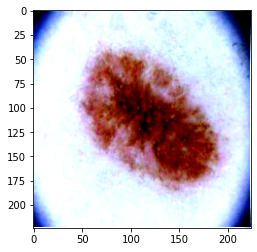

In [ ]:
plt.imshow(img_2.permute(1,2,0))

In [ ]:
total = len(os.listdir( os.path.join(train_folder_path, "Benign"))) + len(os.listdir( os.path.join(train_folder_path, "Malignant")))
class_weights = [ total / len(os.listdir( os.path.join(train_folder_path, "Benign"))), total / len(os.listdir( os.path.join(train_folder_path, "Malignant")))]
val_size = int(0.2 * total);
train_size = total - val_size;

#train_data, val_data = random_split(train_folder, [train_size, val_size])
batch_size = 80
image_weights = [ class_weights[ x[1] ] for x in train_folder ]
sampling = WeightedRandomSampler(image_weights, len(train_folder))
#train_dataloader = DataLoader(train_folder, batch_size = batch_size , shuffle = True)
train_dataloader = DataLoader(train_folder, batch_size = batch_size , sampler=sampling)
#train_dataloader = DataLoader(train_data, batch_size = batch_size, sampler=sampling)
#val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_folder, batch_size = batch_size , shuffle = True)

### Use of transfer learning using pretrained pytorch models
## In order to make use of transfer learning we take an approach where , pretrained weights for higher image dataset are chosen and only the fully connected layer or the last linear layer will be modified to adapt to newer classification problems and the training period is lesser since only weights have to adjusted with respect to the last layer. 

In [ ]:
densenet_161 = models.densenet121(pretrained=True)
num_ftrs = densenet_161.classifier.in_features
densenet_161.classifier = nn.Linear(num_ftrs, 2)
#densenet_161           print the layers and specifications in each layer 
densenet_161.cuda()

In [ ]:
losses = []
accuracies = []
epoches = 60
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_161.parameters(), lr = 0.001)
for epoch in range(epoches):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dataloader:
        X = X.cuda()
        y = y.cuda()
        preds = densenet_161(X)
        loss = loss_fn(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)
        
    epoch_accuracy = epoch_accuracy/len(train_dataloader)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(epoch_loss)
    print("Epoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


............Epoch: 0, train loss: 0.5458, train accracy: 0.7219, time: 13.695164680480957
............Epoch: 1, train loss: 0.4549, train accracy: 0.7948, time: 27.20116376876831
............Epoch: 2, train loss: 0.3722, train accracy: 0.8427, time: 40.83065867424011
............Epoch: 3, train loss: 0.2928, train accracy: 0.8792, time: 54.410789251327515
............Epoch: 4, train loss: 0.3094, train accracy: 0.8677, time: 68.16766309738159
............Epoch: 5, train loss: 0.2364, train accracy: 0.9073, time: 81.96351528167725
............Epoch: 6, train loss: 0.3031, train accracy: 0.8865, time: 95.95610857009888
............Epoch: 7, train loss: 0.2360, train accracy: 0.9000, time: 109.96187376976013
............Epoch: 8, train loss: 0.1905, train accracy: 0.9260, time: 124.02357244491577
............Epoch: 9, train loss: 0.1344, train accracy: 0.9552, time: 138.30762147903442
............Epoch: 10, train loss: 0.1497, train accracy: 0.9365, time: 152.81301856040955
............Ep

In [ ]:
def test():
    # test phase
    densenet_161.eval()

    correct = 0
    total_benign = 304
    total_malignent = 75
    num_mal_pred = 0
    num_ben_pred = 0

    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_dataloader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = densenet_161( batch )
            #print(output.shape)
            # get prediction
            output = torch.argmax(output, 1)
            #print(output.shape)
            #print(target)
            # accumulate correct number
            correct += (output == target).sum().item()
            num_mal_pred += output.sum().item()
            num_ben_pred += len(output) - num_mal_pred
            #print()

    # Calculate test accuracy, specificity    
    acc = 100 * float(correct) / len(test_folder)
    print('Test accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_folder), acc ) )
    print("True Negative Rate (Specificity): {}/{} = {:.2f}".format(num_ben_pred, total_benign, num_ben_pred/total_benign))
    print("True Positive Rate (Sensitivity): {}/{} = {:.2f}".format(num_mal_pred, total_malignent, num_mal_pred/total_malignent))
    print("Type I Error: {:.2f}".format(1 - (num_ben_pred/total_benign)))
    print("Type II Error: {:.2f}".format(1 - (num_mal_pred/total_malignent)))

    print(
        """
        TP = {0}     |     FP = {2}
        FN = {1}     |     TN = {3}
        """.format(num_mal_pred, total_malignent - num_mal_pred, total_benign - num_ben_pred, num_ben_pred)
        )
test()



Test accuracy: 312/379 (82.32%)
True Negative Rate (Specificity): 227/304 = 0.75
True Positive Rate (Sensitivity): 48/75 = 0.64
Type I Error: 0.25
Type II Error: 0.36

        TP = 48     |     FP = 77
        FN = 27     |     TN = 227
        


### Save the model 

In [ ]:
torch.save(densenet_161.state_dict(), '/content/sample_data/skin_lesion.pt')